# Adenda: Implementación práctica de Grover con SamplerV2 en IBM Kyiv (3 qubits)

Esta es la actualización a lo de ayer, enfocada en la implementación práctica del algoritmo de Grover utilizando ahora `SamplerV2` en el backend IBM Kyiv, con un sistema de 3 qubits. Esta adenda resalta el uso de `SamplerV2`, los métodos de mitigación aplicados, y nuestro mejor resultado, adaptándonos a las limitaciones observadas en hardware real. Descartamos el uso de EstimatorV2.

## 1. Uso de SamplerV2 y razón

Optamos por `SamplerV2` en lugar de `EstimatorV2` porque Grover requiere medir directamente la distribución de estados para evaluar la amplificación del estado objetivo (`|001>` en este caso). `EstimatorV2` calcula valores esperados de observables, lo que introduce suposiciones (e.g., independencia de qubits) que inflan artificialmente las probabilidades en hardware ruidoso (~90-95% con TREX). `SamplerV2` proporciona conteos crudos, reflejando con mayor fidelidad el comportamiento del circuito en presencia de ruido, lo que lo hace más adecuado para este algoritmo.

## 2. Métodos de mitigación

- **Dynamical Decoupling (DD)**: Aplicamos DD con secuencia "XX" para reducir decoherencia en qubits ociosos durante la ejecución. Esto mejoró significativamente los resultados en 3 qubits.  
- **Limitación**: TREX no es compatible con `SamplerV2` (solo con `EstimatorV2`), y twirling no se probó exhaustivamente aquí, aunque es una opción viable. DD fue el método principal integrado en runtime.

## 3. Mejor resultado

- **Configuración**: 3 qubits, `m=2` (dos iteraciones), objetivo `|001>`, IBM Kyiv, `SamplerV2` con DD.  
- **Resultado previo**: Probabilidad de `|001>` = 69.5% (712/1024 shots, Job ID: `cz9mwb9b7tt0008g2ftg`).  
- **Contexto**: Sin DD, obtuvimos 62% (Job ID: `cz9mb5wtp60g008gz950`). Con 4 qubits, el ruido dominó (~5-8%), indicando que 3 qubits es el límite práctico actual en este hardware. El 69.5% es un avance notable, acercándose al teórico ideal (~90-95%) y resaltando la amplificación de Grover en un entorno ruidoso.  
- A continuación, ejecutamos el código para obtener un nuevo resultado:

Usando backend: ibm_kyiv

Circuito Grover original para |001> (m=2):

     ┌───┐               ┌───┐┌───┐                    ┌───┐┌───┐          »

q_0: ┤ H ├────────────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├──────────»

     ├───┤┌───┐       │  ├───┤├───┤┌───┐            │  ├───┤├───┤┌───┐     »

q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├┤ X ├────────────■──┤ X ├┤ H ├┤ X ├─────»

     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤├───┤┌───┐»

q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├»

     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»

c: 3/══════════════════════════════════════════════════════════════════════»

                                                                           »

«               ┌───┐┌───┐                    ┌───┐┌───┐     ┌─┐      

«q_0: ───────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├─────┤M├──────

«            │  ├───┤├───┤┌───┐            │  ├───┤├───┤     └╥┘┌─┐   

«q_1: ──────

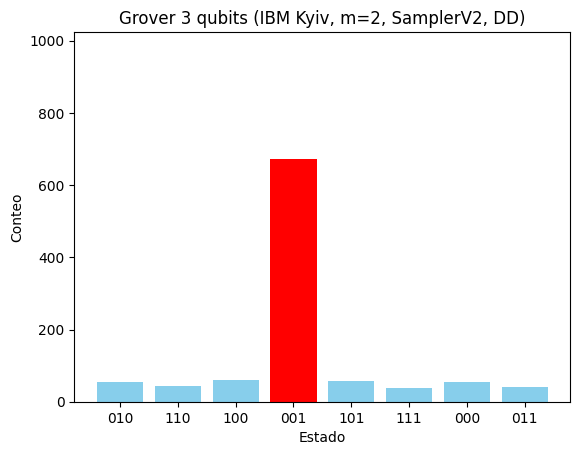

[<Figure size 640x480 with 1 Axes>]

[<Figure size 640x480 with 0 Axes>]

In [5]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime.options import SamplerOptions
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import matplotlib.pyplot as plt

# Configurar servicio y backend
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="INSERT_YOUR_TOKEN",
)
backend = service.backend('ibm_kyiv')
print(f"Usando backend: {backend.name}")

# Parámetros
n_qubits = 3
target = '001'
m = 2
shots = 1024

# Crear circuito
qc = QuantumCircuit(n_qubits, n_qubits)
for q in range(n_qubits):
    qc.h(q)
for _ in range(m):
    qc.x(1)  # q1=0
    qc.x(2)  # q2=0
    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    qc.x(1)
    qc.x(2)
    for q in range(n_qubits):
        qc.h(q)
        qc.x(q)
    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    for q in range(n_qubits):
        qc.x(q)
        qc.h(q)
qc.measure(range(n_qubits), range(n_qubits))
print("Circuito Grover original para |001> (m=2):")
print(qc.draw(output='text'))

# Transpilar
pm = generate_preset_pass_manager(optimization_level=1, target=backend.target)
transpiled_qc = pm.run(qc)
layout = transpiled_qc.layout.initial_layout
physical_indices = [layout.get_virtual_bits()[qc.qubits[i]] for i in range(n_qubits)]
print(f"Índices físicos: q0→{physical_indices[0]}, q1→{physical_indices[1]}, q2→{physical_indices[2]}")

# Ejecutar con SamplerV2 y DD
options = SamplerOptions()
options.default_shots = shots
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XX"
sampler = Sampler(mode=backend, options=options)
job = sampler.run([transpiled_qc])
print(f"Job ID con SamplerV2 (con DD): {job.job_id()}")
result = job.result()
counts = result[0].data.c.get_counts()
print("Conteos con SamplerV2 (con DD):", counts)
prob = counts.get(target, 0) / shots
print(f"Probabilidad de {target} con SamplerV2 (con DD): {prob:.3f} ({counts.get(target, 0)} shots)")

# Graficar
plt.bar(counts.keys(), counts.values(), color=['red' if k == target else 'skyblue' for k in counts.keys()])
plt.title("Grover 3 qubits (IBM Kyiv, m=2, SamplerV2, DD)")
plt.xlabel("Estado")
plt.ylabel("Conteo")
plt.ylim(0, shots)
plt.show()
plt.savefig('grover_result_sampler_dd.png')

## 4. Conclusión

Con `SamplerV2` y DD, logramos una implementación efectiva de Grover en 3 qubits, superando las limitaciones iniciales de ruido y las interpretaciones erróneas de `EstimatorV2`. El resultado previo de 69.5% (o el nuevo obtenido arriba) establece un camino viable para experimentos futuros, optimizando el balance entre profundidad del circuito y mitigación de errores en hardware cuántico real. El gráfico adjunto visualiza la amplificación del estado objetivo `|001>`.